In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 200 characters.
                        #Useful for initial coding.


MAX_OUTPUT_LENGTH = 500 if not EASY_MODE else 100  #maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 10                          #how often to evaluate validation score

### Step 1: preprocessing



In [2]:
import numpy as np
from collections import defaultdict
test_word_to_translation = defaultdict(list) 
all_word_to_translation = defaultdict(list)
train_word_to_translation = defaultdict(list)
bos = '_'
eos = ';'
SIZE_OF_TRAIN = 0
SIZE_OF_TEST = 0
with open("train.txt") as fin:
    for line in fin:
        
        word,trans = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>MAX_OUTPUT_LENGTH:
                continue
        
        train_word_to_translation[word].append(trans)
        all_word_to_translation[word].append(trans)
        SIZE_OF_TRAIN += 1
        
with open("test.txt") as fin:
    for line in fin:
        
        word,trans = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>MAX_OUTPUT_LENGTH:
                continue
        
        all_word_to_translation[word].append(trans)
        test_word_to_translation[word].append(trans)
        
        SIZE_OF_TEST += 1

print ("size = ",len(all_word_to_translation))
print("size of train = ", SIZE_OF_TRAIN)
print("test = ", SIZE_OF_TEST)

size =  3771
size of train =  18836
test =  2093


In [3]:
#get all unique lines in source language
train_words = np.array(list(train_word_to_translation.keys()))
# get all unique lines in translation language
train_translations = np.array([ts for all_ts in train_word_to_translation.values() for ts in all_ts])

all_words = np.array(list(all_word_to_translation.keys()))
all_translations = np.array([ts for all_ts in all_word_to_translation.values() for ts in all_ts])

test_words = np.array(list(test_word_to_translation.keys()))
test_translations = np.array([ts for all_ts in test_word_to_translation.values() for ts in all_ts])

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [4]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [5]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['июне 2012 года' '1979 году' '24 апреля' 'апреле 2012 года'
 'декабре 2011 года']

words to ids (0 = bos, 1 = eos):
[[ 0 30  9 34 35 27 33 13 31 33 27  2 14 12 11  1  1  1  1]
 [ 0 31 36  7 36 27  2 14 12 24  1  1  1  1  1  1  1  1  1]
 [ 0 33  8 27 11 38 37 35  4 28  1  1  1  1  1  1  1  1  1]
 [ 0 11 38 37 35  4 35 27 33 13 31 33 27  2 14 12 11  1  1]
 [ 0 12 35  6 11 21 37 35 27 33 13 31 31 27  2 14 12 11  1]]

back to words
['июне 2012 года', '1979 году', '24 апреля', 'апреле 2012 года', 'декабре 2011 года']


Draw word/translation length distributions to estimate the scope of the task.

(0, 500)

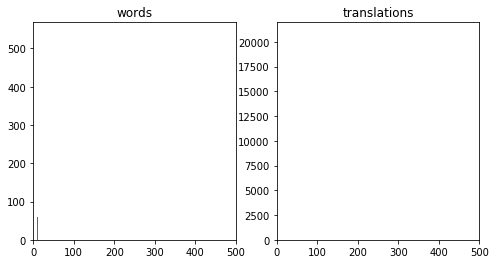

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len,all_words)),bins=100);
plt.xlim(0, 500)

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)),bins=100);
plt.xlim(0, 500)



### Step 2: deploy encoder-decoder (2 points)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of words and their translations. Computes the log-probabilities of all possible characters given english prefices and word.
* __`model.weights`__ - weights from all model layers [a list of variables]

In [7]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()


In [8]:
from basic_model import BasicTranslationModel
model = BasicTranslationModel('model',inp_voc,out_voc,
                              emb_size=32, hid_size=64)

s.run(tf.global_variables_initializer())

/home/cheshire/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])
out = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])

# translate inp (with untrained model)
sampled_out, logp = out,model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n",out,logp)
print("\nSample translations:\n", s.run(sampled_out))


Symbolic_translate output:
 Tensor("PlaceholderWithDefault_1:0", shape=(?, ?), dtype=int32) (<tf.Tensor 'transpose_2:0' shape=(?, ?) dtype=int32>, <tf.Tensor 'Reshape_1:0' shape=(?, ?, 20) dtype=float32>)

Sample translations:
 [[5 7 5 6 9]
 [6 1 1 0 8]
 [1 6 9 5 8]]


In [10]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp,out)
print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:,:2,:5])


Symbolic_score output:
 Tensor("Reshape_3:0", shape=(?, ?, 20), dtype=float32)

Log-probabilities (clipped):
 [[[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -3.001841   -2.9856806  -3.0063896  -2.9578001  -2.9635713]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -2.964001   -2.9819436  -3.0434053  -3.0349877  -2.9507852]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -2.9545949  -3.0105648  -2.99196    -3.0363212  -2.9295094]]]


In [11]:
input_sequence = tf.placeholder('int32', [None,None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)
    
def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)
    

In [12]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert isinstance(greedy_translations,tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['июне 2012 года' '1979 году' '24 апреля']
Dummy translations: ['y9311д9 4', '8 3mоd59930оdm994', 'yдоdд3010y']
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [13]:
import editdistance # !pip install editdistance

def get_distance(word,trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = all_word_to_translation[word]
    assert len(references)!=0,"wrong/unknown word"
    return min(editdistance.eval(trans,ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words,np.ndarray)
    
    batch_words = np.random.choice(words,size=bsize,replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance,batch_words,batch_trans))
    
    return np.array(distances,dtype='float32')

In [14]:
[score(test_words,10).mean() for _ in range(5)]

[9.5, 9.5, 9.8, 9.3, 10.8]

## Step 3: Training (2 points)

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [15]:
# import utility functions
from basic_model import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32',[None,None])
    reference_answers = tf.placeholder('int32',[None,None])
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)
    
    # compute mean crossentropy
    crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)
    
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    
    loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)
    
    # Build weights optimizer. Use model.weights to get all trainable params.
    opt = tf.train.AdamOptimizer()
    updates = opt.compute_gradients(loss, model.weights)
    optimizer = opt.apply_gradients(updates)
    train_step = optimizer
    
    
# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

Actually run training on minibatches

In [16]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words,size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get,batch_words))
    batch_trans = list(map(random.choice,batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [17]:
bx,by = sample_batch(train_words, all_word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[ 0 33 27 34 14 28 21 37 28 27 33 13 31 13 27  2 14 12 11  1]
 [ 0 20 35 34 40 28 21 37 41  1  1  1  1  1  1  1  1  1  1  1]
 [ 0 31 33 27 14  6 40 28 21 37 28  1  1  1  1  1  1  1  1  1]]
Target:
[[ 0  6  3 16 15 15 16  3  6 15  6  1]
 [ 0  9  9 16  6 13 16  4  4  4  4  1]
 [ 0 15  3 16 15  6 16  4  4  4  4  1]]


KeyboardInterrupt: 

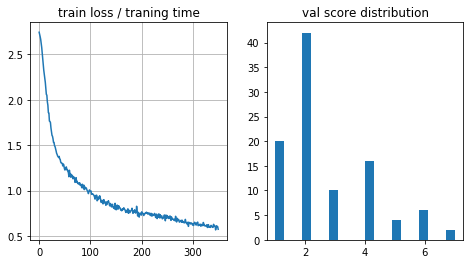

In [18]:
from IPython.display import clear_output
from tqdm import tqdm,trange #or use tqdm_notebook,tnrange

loss_history=[]
editdist_history = []

for i in trange(5000):
    bx,by = sample_batch(train_words, all_word_to_translation, 128)
    
    feed_dict = {
        supervised_training.input_sequence:bx,
        supervised_training.reference_answers:by
    }
    
    loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
        
# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [19]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

июне 2012 года -> dd.04.2007
1979 году -> dd.mm.1999
24 апреля -> 27.05.yyyy
апреле 2012 года -> dd.04.2007
декабре 2011 года -> dd.01.1999
мае 2011 года -> dd.04.2007
3 марта -> 11.07.yyyy
14 февраля -> 12.09.yyyy
11 февраля 2012 года -> 11.02.2007
29 января 2011 года -> 24.01.2007


In [20]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:", np.mean(test_scores))


100%|██████████| 28/28 [00:00<00:00, 86.21it/s]

Supervised test score: 2.7794285714285714


  7%|▋         | 349/5000 [00:40<08:53,  8.72it/s]

# Attention


In [21]:
def run_eval(words, training, bsize=100):
    # Prepare any operations you want here
    def translate(lines, training):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(training.greedy_translations, {training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)
    
    def score(words, training, bsize=100):
        """a function that computes levenshtein distance for bsize random samples"""
        assert isinstance(words,np.ndarray)

        batch_words = np.random.choice(words,size=bsize,replace=False)
        batch_trans = translate(batch_words, training)

        distances = list(map(get_distance,batch_words,batch_trans))

        return np.array(distances,dtype='float32')
    return score(words, training, bsize)
    

In [22]:
def run_model(model, n_steps=25000, lr=1e-3):
    class supervised_training:
        # variable for inputs and correct answers
        input_sequence = tf.placeholder('int32',[None,None])
        reference_answers = tf.placeholder('int32',[None,None])

        greedy_translations, _ = model.symbolic_translate(input_sequence, greedy=True)

        # Compute log-probabilities of all possible tokens at each step. Use model interface.
        logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

        # compute mean crossentropy
        crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)

        mask = infer_mask(reference_answers, out_voc.eos_ix)

        loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)

        # Build weights optimizer. Use model.weights to get all trainable params.
        opt = tf.train.AdamOptimizer(lr)
        updates = opt.compute_gradients(loss, model.weights)
        optimizer = opt.apply_gradients(updates)
        train_step = optimizer
    
    def translate(lines):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)
        

        # Compute translations in form of indices
        trans_ix = s.run(supervised_training.greedy_translations, 
                         {supervised_training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)
    
    
    # intialize optimizer params while keeping model intact
    initialize_uninitialized(s)
    
    loss_history=[]
    editdist_history = []

    try:
        for i in trange(n_steps):
            bx,by = sample_batch(train_words, all_word_to_translation, 64)

            feed_dict = {
                supervised_training.input_sequence:bx,
                supervised_training.reference_answers:by
            }

            loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
            loss_history.append(loss)

            if (i+1)%REPORT_FREQ==0:
                clear_output(True)
                current_scores = run_eval(test_words, supervised_training)
                editdist_history.append(current_scores.mean())
                plt.figure(figsize=(12,4))
                plt.subplot(131)
                plt.title('train loss / traning time')
                plt.plot(loss_history)
                plt.grid()
                plt.subplot(132)
                plt.title('val score distribution')
                plt.hist(current_scores, bins = 20)
                plt.subplot(133)
                plt.title('val score / traning time')
                plt.plot(editdist_history)
                plt.grid()
                plt.show()
                print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
    except KeyboardInterrupt:
        print ('KeyboardInterrupted - enought learning')
        
    for word in train_words[:10]:
        print("%s -> %s"%(word,translate([word])[0]))
    
    test_scores = []
    for start_i in trange(0,len(test_words),32):
        batch_words = test_words[start_i:start_i+32]
        batch_trans = translate(batch_words)
        distances = list(map(get_distance,batch_words,batch_trans))
        test_scores.extend(distances)

    print("Supervised test score:", np.mean(test_scores))

In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
import imp

In [25]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc, emb_size=254, hid_size=254, 
                                     attention_fun='simple', bidirectional=False, init='random')

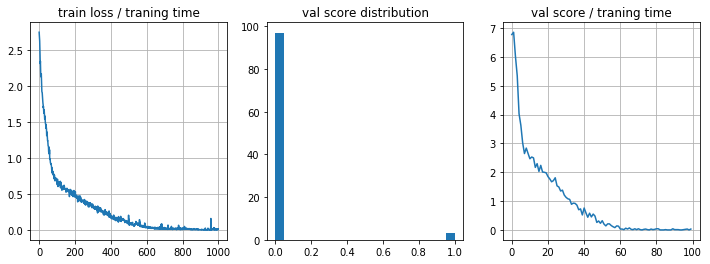

  0%|          | 0/28 [00:00<?, ?it/s]

llh=0.011, mean score=0.012
июне 2012 года -> dd.06.2012
1979 году -> dd.mm.1949
24 апреля -> 24.04.yyyy
апреле 2012 года -> dd.04.2012
декабре 2011 года -> dd.12.2011
мае 2011 года -> dd.05.2011
3 марта -> 03.03.yyyy
14 февраля -> 14.02.yyyy
11 февраля 2012 года -> 11.02.2012
29 января 2011 года -> 29.01.2011


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]

Supervised test score: 0.04


In [26]:
run_model(model, 1000)

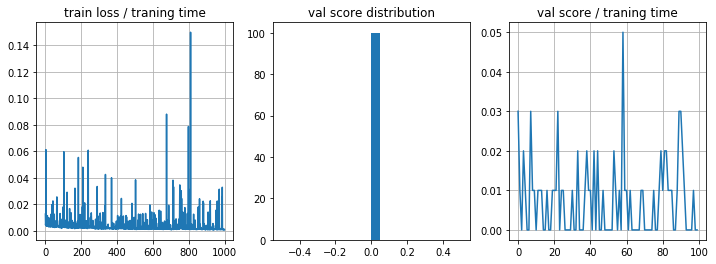

100%|██████████| 1000/1000 [10:00<00:00,  1.66it/s]

llh=0.001, mean score=0.007
июне 2012 года -> dd.06.2012
1979 году -> dd.mm.1979
24 апреля -> 24.04.yyyy
апреле 2012 года -> dd.04.2012
декабре 2011 года -> dd.12.2011
мае 2011 года -> dd.05.2011
3 марта -> 03.03.yyyy
14 февраля -> 14.02.yyyy



  0%|          | 0/28 [00:00<?, ?it/s]

11 февраля 2012 года -> 11.02.2012
29 января 2011 года -> 29.01.2011


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]

Supervised test score: 0.006857142857142857


In [27]:
run_model(model, 1000, 1e-4)

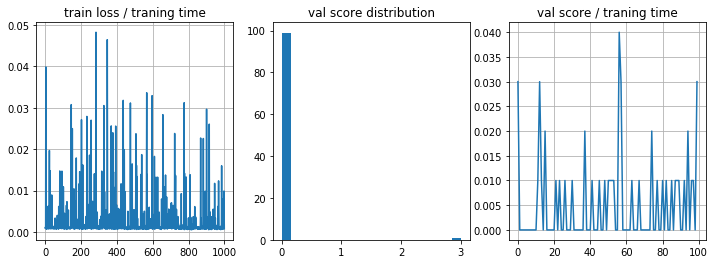

100%|██████████| 1000/1000 [09:53<00:00,  1.68it/s]

llh=0.003, mean score=0.008
июне 2012 года -> dd.06.2012
1979 году -> dd.mm.1979
24 апреля -> 24.04.yyyy
апреле 2012 года -> dd.04.2012
декабре 2011 года -> dd.12.2011
мае 2011 года -> dd.05.2011
3 марта -> 03.03.yyyy
14 февраля -> 14.02.yyyy
11 февраля 2012 года -> 11.02.2012



  0%|          | 0/28 [00:00<?, ?it/s]

29 января 2011 года -> 29.01.2011


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]

Supervised test score: 0.006857142857142857


In [29]:
run_model(model, 1000, 1e-5)